In [22]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime, timedelta
from math import sqrt as math_sqrt
from sklearn.metrics import mean_squared_error
import pickle
import math
import random
import sys
from tqdm import tqdm
import scipy

#Import custom modules
sys.path.append('../')
from utils.utils import *

In [3]:
training_data, testing_data, testing_index = load_data()
countries, no_features, feature_names, years, months, weekdays, hours = load_data_information()
n_years = len(years)

In [4]:
#Reshape data to only include middle day
training_data = training_data[:,2*24:3*24]
testing_data = testing_data[:,2*24:3*24]
testing_index = testing_index[:,2*24:3*24]

In [8]:
# Extracts features, year, etc. from whole data
def change_format(input_data, filtering = True):
    #Extract year from data matrix
    year_w = input_data[:,:,0:1]
    #Extract country from data matrix
    country_w = input_data[:,:,3:4]   
    #Extract features from matrix
    features_w = input_data[:,:,5:5+no_features]
    #Extract matrix of missing values from data matrix
    miss_vals_w = input_data[:,:,-no_features-6:-6]
    #Extract pos enc from data matrix
    pos_enc_w = input_data[:,:,-6:]


    #Prepare format for features
    features_tf = np.reshape(features_w, [features_w.shape[0], -1, 1])
    miss_vals_tf = np.reshape(miss_vals_w, [features_w.shape[0], -1, 1])
    pos_enc_tf = np.reshape(tf.transpose(np.repeat(np.reshape(pos_enc_w, [pos_enc_w.shape[0], pos_enc_w.shape[1], pos_enc_w.shape[2], 1]), no_features, axis = 3), perm=[0,1,3,2]),[pos_enc_w.shape[0],-1,pos_enc_w.shape[2]])
    feature_nr_tf = np.repeat(np.reshape(np.repeat(np.reshape(np.array(range(no_features)),[1,-1]), input_data.shape[1], axis = 0),[1,-1]), input_data.shape[0], axis = 0)
    
    #Reshape other features
    year_tf = np.reshape(np.repeat(year_w, no_features,axis=2),[input_data.shape[0],-1])
    country_tf = np.reshape(np.repeat(country_w, no_features,axis=2),[input_data.shape[0],-1])
    if filtering == True:
        #Filter data
        filtering = np.squeeze(miss_vals_tf.sum(axis=1) > 0)
        #Filter features
        features = features_tf[filtering,:,:]
        #Filter mask
        mask = miss_vals_tf[filtering,:,:]
        #Filter positional encoding
        pos_enc = pos_enc_tf[filtering,:,:]
        #Filtering year
        year = year_tf[filtering,:]
        #Filtering country
        country = country_tf[filtering,:]
        #Filtering feature number
        feature_nr = feature_nr_tf[filtering,:]
        return [features, mask, pos_enc, country, year, feature_nr]
    else:
        return features_tf, miss_vals_tf, pos_enc_tf, country_tf, year_tf, feature_nr_tf

## Analyze predictions

In [16]:
testing_data.shape

(5172, 24, 37)

In [18]:
_, mask_full, _, _, _, _ = change_format(testing_data,False)
_, mask_filtered, _, _, _, _ = change_format(testing_data,True)

In [19]:
predictions_filtered = np.load("../evaluation/masks/testing_distribution_filtered.npy")
predictions_full = np.load("../evaluation/masks/testing_distribution_full.npy")

In [31]:
def get_count_plot(predictions, mask):
    data_plot = pd.DataFrame(columns = ["Estimation", "Ground truth"])
    data_plot["Estimation"] = np.squeeze(predictions.sum(axis = 1))
    data_plot["Ground truth"] = np.squeeze(mask.sum(axis = 1))
    data_plot = data_plot.melt()

    fig, axs = plt.subplots(1,2, figsize = (18,8))
    axs = axs.ravel()
    sns.histplot(data_plot, x ="value", hue = "variable", ax = axs[0], stat = "density", bins = 50, kde = True, multiple = "layer", binrange = (0,200))
    axs[0].set_title("Histogram", size = 18)
    axs[0].set_xlabel("Missing values per day", size = 16)

    sns.ecdfplot(data_plot, x ="value", hue = "variable", ax = axs[1])
    axs[1].set_title("Empirical CDF", size = 18)
    axs[1].set_xlabel("Missing values per day", size = 16)
    
    pred_sum = np.squeeze(predictions.sum(axis = 1))
    pred_hist = np.histogram(pred_sum, bins = 200, density = True, range = (0,200))
    test_sum = np.squeeze(mask.sum(axis = 1))
    test_hist = np.histogram(test_sum, bins = 200, density = True, range = (0,200))
    print("Wasserstein disctance: {}".format(scipy.stats.wasserstein_distance(pred_hist[0], test_hist[0])))

Wasserstein disctance: 0.0007772621809744784


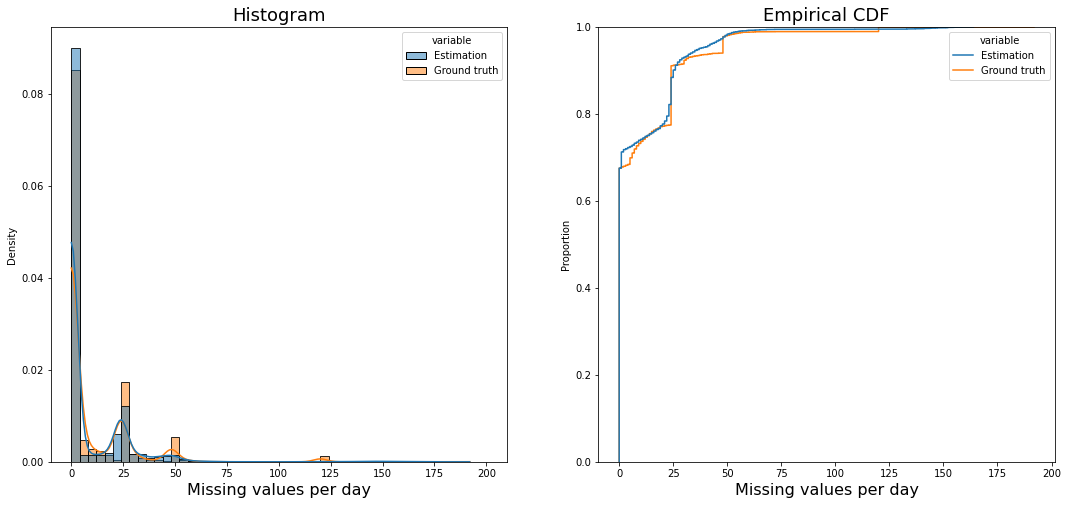

In [35]:
get_count_plot(predictions_full,mask_full)
plt.savefig("count_full_data.pdf",bbox_inches = "tight", dpi = 300)

Wasserstein disctance: 0.002505952380952382


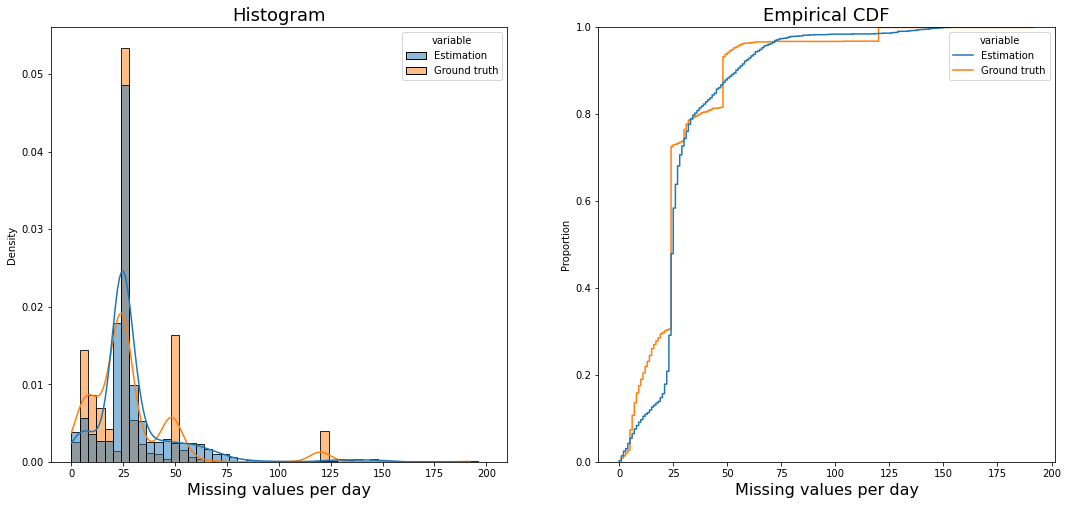

In [36]:
get_count_plot(predictions_filtered,mask_filtered)
plt.savefig("count_filtered_data.pdf",bbox_inches = "tight", dpi = 300)